# HW2P2: Face Classification and Verification


This is the second homework in 11785: Introduction to Deep Learning consisting of two parts:
*   Face Recognition: You will be writing your own CNN model to tackle the problem of classification, consisting of 7001 identities.
*   Face Verification: You use the model trained for classification to evaluate the quality of its feature embeddings, by comparing the similarity of known and unknown identities.

For this HW, you only have to write code to implement your model architecture. Everything else has been provided for you, on the pretext that most of your time will be used up in developing the suitable model architecture for achieving satisfactory performance.

Common errors which you may face in this homeworks (because of the size of the model)


*   CUDA Out of Memory (OOM): You can tackle this problem by (1) Reducing the batch size (2) Calling `torch.cuda.empty_cache()` and `gc.collect()` (3) Finally restarting the runtime



# TODOs
As you go, please read the code and keep an eye out for TODOs.

**Structure of this notebook**:

1. **Libraries** - just run it
2. **Kaggle** - copy the code from HW1P2 and add a correct API key
3. **Configs** - specify your configs
4. **Dataset**
  - **Datasets and Dataloaders** - it's already implemented, just specify your preferred augmentations/transformations
  - **EDA and Viz** - just run it to check if your augmentations/transformations worked
5. **Model Architecture** - implement and define your preferred model architecture
6. **Loss, Optimizer, and Scheduler** - define your loss, optimizer, and a scheduler
7. **Training and Validation Functions** - includes functions for both classification and verification tasks
  - **Classification Task** - just run it
  - **Verification Task** - just run it
8. **Wandb** - add a correct API key
9. **Experiments** - make changes if needed; it will show you train/val/test accuracy for both classification and verification. **Important**: make sure you save your best model checkpoints because models in this HW take a long time to get trained
10. **Testing and Kaggle Submission** - just run it
11. **Model Finetuning** - this part might help you get a higher score on the verification part
  - **Model Implementations (CenterLoss, ArcFace, or SphereFace)** - please refer to the additional notebook and just copy the model from there
  - **Model Definition (finetuning)** - you may reuse the code from the main part
  - **Loss, Optimizer, and Scheduler Definition (finetuning)** - you may reuse the code from the main part
  - **Training Function (finetuning)** - you may reuse the code from the main part
  - **Wandb (finetuning)** - you may reuse the code from the main part
  - **Experiments (finetuning)** - you may reuse the code from the main part

Good luck!

# Libraries

In [2]:
!nvidia-smi # Run this to see what GPU you have

ERROR: Option # is not recognized. Please run 'nvidia-smi -h'.



#NOTE: RESTART THE RUN TIME AFTER RUNNING THE THE CELL BELOW

In [3]:
# Install the necessary packages. Very important: Please restart your session in Colab/Local Machine
# You can restart your session in colab by going to Runtime and then clicking restart session
!pip install wandb --quiet
!pip install torch==1.12.1 torchvision==0.13.1 torchaudio==0.12.1

Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Ignored the following yanked versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3, 0.15.0
ERROR: Could not find a version that satisfies the requirement torchvision==0.13.1 (from versions: 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.16.2, 0.17.0, 0.17.1)
ERROR: No matching distribution found for torchvision==0.13.1


In [1]:
# Import the important packages for this Homework. Feel free to add anything here you need.
import torch
from torchsummary import summary
import torchvision # This library is used for image-based operations (Augmentations)
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import glob
import wandb
import matplotlib.pyplot as plt
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)


Device:  cuda


In [ ]:
from google.colab import drive # Link to your drive if you are not using Colab with GCP
drive.mount('/content/drive') # Models in this HW take a long time to get trained and make sure to save it here

# Kaggle

In [2]:
# TODO: Use the same Kaggle code from HW1P2
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"xiaocmumsppm", "key":"ff2230c7aaef22ec98252b82537c0f73"}')
    # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

^C


The syntax of the command is incorrect.


FileNotFoundError: [Errno 2] No such file or directory: '/root/.kaggle/kaggle.json'

     ---------------------------------------- 0.0/59.2 kB ? eta -:--:--
     ------------- ------------------------ 20.5/59.2 kB 640.0 kB/s eta 0:00:01
     -------------------------------------- 59.2/59.2 kB 777.1 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for kaggle: filename=kaggle-1.5.8-py3-none-any.whl size=73262 sha256=c1437e6e53612cdc8efd9538479854279d1012c776905a4a643982799d57bebc
  Stored in directory: c:\users\sx119\appdata\local\pip\cache\wheels\b5\23\bd\d33cbf399584fa44fa049711892d333954a50ed4b86948109e
Successfully built kaggle


In [2]:
# Reminder: Make sure you have connected your kaggle API before running this block
!mkdir '/content/data'

!kaggle competitions download -c 11785-hw2p2-face-recognition
!unzip -qo '11785-hw2p2-face-recognition.zip' -d '/content/data'

!kaggle competitions download -c 11785-hw2p2-face-verification
!unzip -qo '11785-hw2p2-face-verification.zip' -d '/content/data'

The syntax of the command is incorrect.


Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\sx119\.conda\envs\mypytorch\Scripts\kaggle.exe\__main__.py", line 4, in <module>
  File "C:\Users\sx119\.conda\envs\mypytorch\Lib\site-packages\kaggle\__init__.py", line 19, in <module>
    from kaggle.api.kaggle_api_extended import KaggleApi
  File "C:\Users\sx119\.conda\envs\mypytorch\Lib\site-packages\kaggle\api\__init__.py", line 22, in <module>
    from kaggle.api.kaggle_api_extended import KaggleApi
  File "C:\Users\sx119\.conda\envs\mypytorch\Lib\site-packages\kaggle\api\kaggle_api_extended.py", line 75, in <module>
    from slugify import slugify
ModuleNotFoundError: No module named 'slugify'
'unzip' is not recognized as an internal or external command,
operable program or batch file.
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
 

# Configs

In [2]:
config = {
    'batch_size': 32, # Increase this if your GPU can handle it
    'lr': 0.0005,
    'epochs': 60, # 20 epochs is recommended ONLY for the early submission - you will have to train for much longer typically.
    # Include other parameters as needed.
}

# Dataset

## Datasets and Dataloaders

In [3]:
# --------------------------------------------------- #

# Data paths

DATA_DIR    = r"C:\Users\sx119\Desktop\11785data\data\11-785-s24-hw2p2-classification" # TODO: Path where you have downloaded the classificaation data
TRAIN_DIR   = os.path.join(DATA_DIR, "train")
VAL_DIR     = os.path.join(DATA_DIR, "dev")
TEST_DIR    = os.path.join(DATA_DIR, "test")

# --------------------------------------------------- #

# Transformations/augmentations of the Train dataset

"""
Refer https://pytorch.org/vision/stable/transforms.html
Implementing the right train transforms/augmentation methods is key to improving performance.
Most torchvision transforms are done on PIL images. So you convert it into a tensor at the end with ToTensor()
But there are some transforms which are performed after ToTensor() : e.g - Normalization
#Normalization Tip - Do not blindly use normalization that is not suitable for this dataset
"""

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(degrees=20),
    torchvision.transforms.ColorJitter(brightness=0.1),
    torchvision.transforms.ColorJitter(contrast=0.1),
    torchvision.transforms.ColorJitter(saturation=0.1),
    torchvision.transforms.ColorJitter(hue=0.1),

    torchvision.transforms.ToTensor(),
    ]) # TODO: Specify transformations/augmentations performed on the train dataset

# --------------------------------------------------- #

# Transformations/augmentations of the Val dataset

"""
You should NOT have data augmentation on the validation set. Why?
"""

valid_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
    ]) # TODO: Specify transformations performed on the val dataset

# --------------------------------------------------- #

# Initializing the train and val datasets

train_dataset   = torchvision.datasets.ImageFolder(TRAIN_DIR, transform = train_transforms)
valid_dataset   = torchvision.datasets.ImageFolder(VAL_DIR, transform = valid_transforms)

# --------------------------------------------------- #

# Initializing the train and val dataloaders

train_loader = torch.utils.data.DataLoader(dataset       = train_dataset,
                                           batch_size    = config['batch_size'],
                                           shuffle        = True,
                                           num_workers = 4, # Uncomment this line if you want to increase your num workers
                                           pin_memory    = True)

valid_loader = torch.utils.data.DataLoader(dataset       = valid_dataset,
                                           batch_size    = config['batch_size'],
                                           shuffle        = False,
                                           num_workers = 2 # Uncomment this line if you want to increase your num workers
                                           )

In [4]:
# --------------------------------------------------- #

# Test dataset class

"""
You can do this with ImageFolder as well, but it requires some tweaking
"""

class TestDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, transforms):
        self.data_dir   = data_dir
        self.transforms = transforms

        # This one-liner basically generates a sorted list of full paths to each image in the test directory
        self.img_paths  = list(map(lambda fname: os.path.join(self.data_dir, fname), sorted(os.listdir(self.data_dir))))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        return self.transforms(Image.open(self.img_paths[idx]))

# --------------------------------------------------- #

# Initializing the test dataset

"""
Why are we using val_transforms for Test Data?
"""

test_dataset = TestDataset(TEST_DIR, transforms = valid_transforms)

# --------------------------------------------------- #

# Initializing the test dataloader

test_loader = torch.utils.data.DataLoader(dataset    = test_dataset,
                                          batch_size = config['batch_size'],
                                          shuffle     = False,
                                          drop_last  = False,
                                          num_workers = 2 # Uncomment this line if you want to increase your num workers
                                          )

## EDA and Viz

In [5]:
# Double-check your dataset/dataloaders work as expected

print("Number of classes    : ", len(train_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Val batches          : ", valid_loader.__len__())

# Feel free to print more things if needed

Number of classes    :  7001
No. of train images  :  140020
Shape of image       :  torch.Size([3, 224, 224])
Batch size           :  32
Train batches        :  4376
Val batches          :  1094


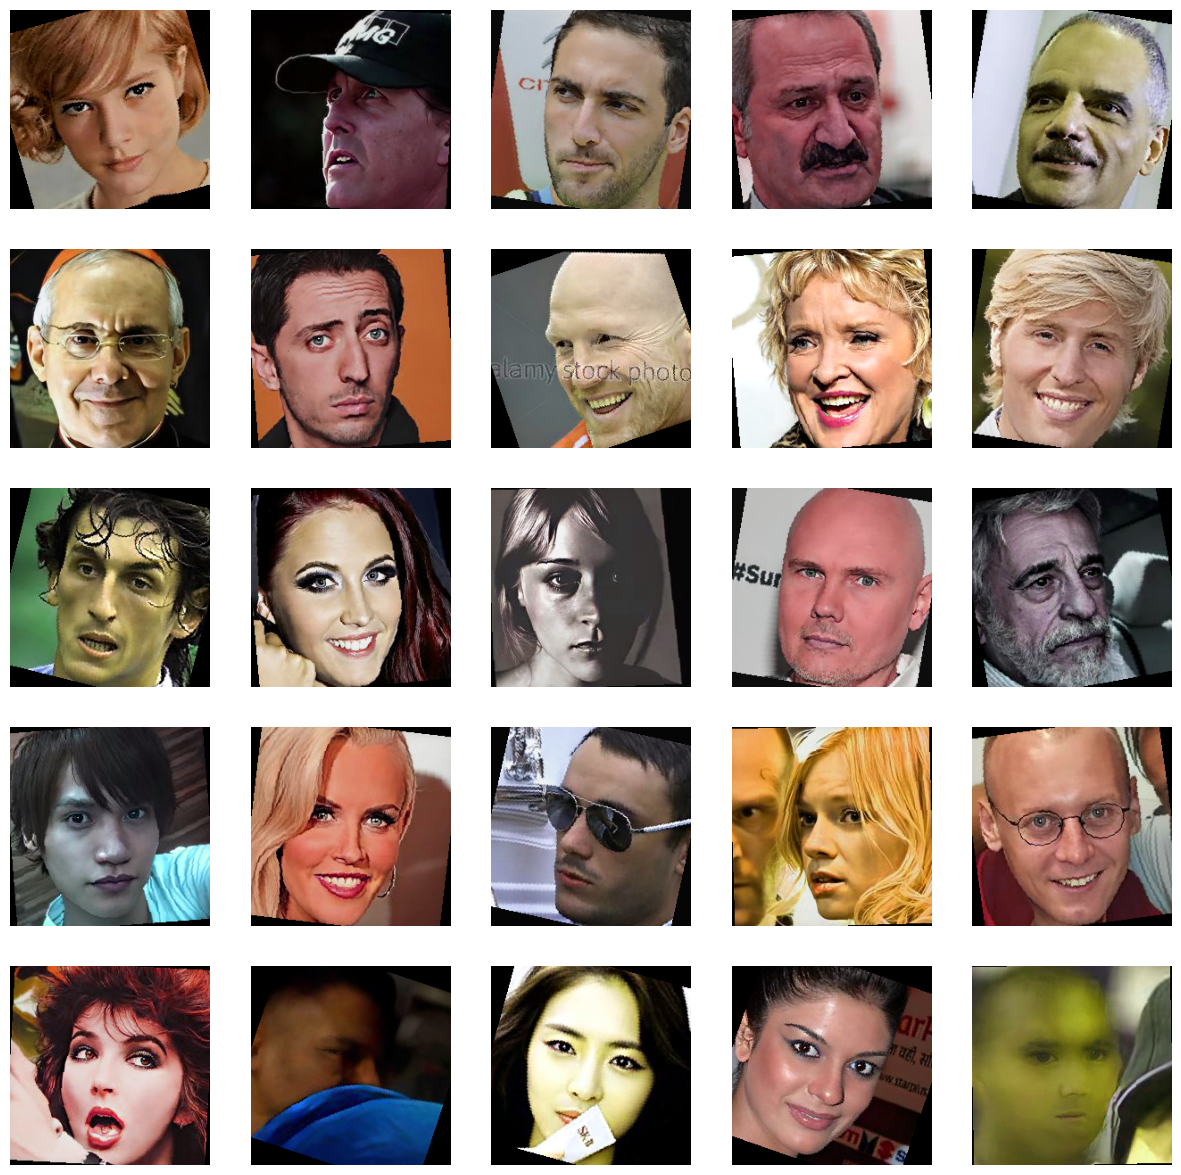

In [7]:
# Visualize a few images in the dataset

"""
You can write your own code, and you don't need to understand the code
It is highly recommended that you visualize your data augmentation as sanity check
"""

r, c    = [5, 5]
fig, ax = plt.subplots(r, c, figsize= (15, 15))

k       = 0
dtl     = torch.utils.data.DataLoader(
    dataset     = torchvision.datasets.ImageFolder(TRAIN_DIR, transform= train_transforms), # dont wanna see the images with transforms
    batch_size  = config['batch_size'],
    shuffle     = True)

for data in dtl:
    x, y = data

    for i in range(r):
        for j in range(c):
            img = x[k].numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k+=1
    break

del dtl

# Model Architecture

FAQ:

**What's a very low early deadline architecture (mandatory early submission)**?

- The very low early deadline architecture is a 5-layer CNN. Keep in mind the parameter limit is 18M.
- The first convolutional layer has 64 channels, kernel size 7, and stride 4. The next four have 128, 256, 512 and 1024 channels. Each have kernel size 3 and stride 2. Documentation to make convolutional layers: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
- Think about strided convolutions from the lecture, as convolutions with stride = 1 and downsampling. For strided convolution, what padding do you need for preserving the spatial resolution? (Hint => padding = kernel_size // 2) - Think why?
- Each convolutional layer is accompanied by a Batchnorm and ReLU layer.
- Finally, you want to average pool over the spatial dimensions to reduce them to 1 x 1. Use AdaptiveAvgPool2d. Documentation for AdaptiveAvgPool2d: https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
- Then, remove (Flatten?) these trivial 1x1 dimensions away.
Look through https://pytorch.org/docs/stable/nn.html


**Why does a very simple network have 4 convolutions**?

Input images are 224x224. Note that each of these convolutions downsample. Downsampling 2x effectively doubles the receptive field, increasing the spatial region each pixel extracts features from. Downsampling 32x is standard for most image models.

**Why does a very simple network have high channel sizes**?

Every time you downsample 2x, you do 4x less computation (at same channel size). To maintain the same level of computation, you 2x increase # of channels, which increases computation by 4x. So, balances out to same computation. Another intuition is - as you downsample, you lose spatial information. We want to preserve some of it in the channel dimension.

**What is return_feats?**

It essentially returns the second-to-last-layer features of a given image. It's a "feature encoding" of the input image, and you can use it for the verification task. You would use the outputs of the final classification layer for the classification task. You might also find that the classification outputs are sometimes better for verification too - try both.

In [6]:
class ArcFaceModel(torch.nn.Module):
    '''
    To train in a standard training loop make sure to modify the train function so you pass in the inputs and the labels
    i.e. output = model(images, labels)
    Experiment with different values of margin and scaler
    '''
    def __init__(self, model, margin=0.2, scaler=10, embedding_size = 512, num_classes= 7001):
        super(ArcFaceModel, self).__init__()
        self.embedding_size = embedding_size
        self.num_classes = num_classes

        # small number to avoid invalid arcCos values
        self.eps = 1e-7

        # hyperparameters
        self.margin = margin
        self.scaler = scaler

        # load classification model
        self.model = model

        # Initializing the arcface linear layer with the weights of the classifier from the trained CNN
        self.AFL_linear = torch.nn.Linear(embedding_size, num_classes, bias=False) # Why set bias=False? Check out the paper.
        with torch.no_grad():
          self.AFL_linear.weight.copy_(self.model.cls_layer.weight)

        # Initializing utility functions for normalization, arcCos, cos and onehot encoding
        self.normalizer = torch.nn.functional.normalize
        self.arcCos = torch.acos
        self.cos = torch.cos
        self.one_hot = torch.nn.functional.one_hot


    def forward(self, x, labels):
        # Get face embedding. Note that we pass return_feats=True to get the image's features and not the final logits.
        embedding = self.model(x, return_feats=True)

        # Normalize face embedding
        embedding = self.normalizer(embedding)

        # Normalize linear layer weights.
        # NOTE: The normalized weights need to be wrapped in torch.nn.Parameter before assigning to AFL_linear.
        with torch.no_grad():
          self.AFL_linear.weight = torch.nn.Parameter(self.normalizer(self.AFL_linear.weight))

        # Take dot product to get cos theta, remember that Wx = ||W||||x||cos(\theta) and ||W|| = 1, ||x|| = 1
        cosine = self.AFL_linear(embedding)

        # We clamp the values to be a little higher than -1 and a little lower than one so we don't get nan values when we call arccos
        cosine = torch.clamp(cosine, min=-1.0+self.eps, max=1.0-self.eps)

        # Get theta by performing arccos(cos(theta))
        theta = self.arcCos(cosine)

        # Convert labels to one-hot
        one_hot_labels = self.one_hot(labels, self.num_classes)
        # Create a mask with m at positions with label 1 and 0 at positions with label 0
        margin_mask = one_hot_labels * self.margin
        # Add margin m to theta
        theta_m = theta + margin_mask

        # calculate the cosine value for theta with margin added and scale with self.scaler
        # this value is then passed to crossEntropyLoss in train loop to calculate arcface loss
        logits = self.scaler * torch.cos(theta_m)
        
        return logits

class SELayer(torch.nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(channel, channel // reduction, bias=False),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(channel // reduction, channel, bias=False),
            torch.nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class ResidualBlock(torch.nn.Module):
    def __init__(self, inchannels, out_channels, stride = 1):
        super(ResidualBlock, self).__init__()
        self.bn1 = torch.nn.BatchNorm2d(inchannels)
        self.conv1 = torch.nn.Conv2d(inchannels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False)
        
        self.prelu = torch.nn.PReLU()

        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
        
        self.selayer = SELayer(out_channels)

        self.shortcut = torch.nn.Sequential()

        if stride != 1 or inchannels != out_channels:
            self.shortcut = torch.nn.Sequential(torch.nn.Conv2d(inchannels, out_channels, stride = stride, kernel_size = 1, bias = False),
                                                torch.nn.BatchNorm2d(out_channels))

    def forward(self, x):
        residual = x
        out = self.bn1(x)
        out = self.prelu(out)
        out = self.conv1(out)

        out = self.bn2(out)
        out = self.prelu(out)
        out = self.conv2(out)

        out = self.selayer(out)

        out += self.shortcut(residual)
        out = self.prelu(out)

        return out


# TODO: Fill out the model definition below

class Network(torch.nn.Module):

    def __init__(self, num_classes=7001):
        super(Network, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.maxpool = torch.nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        self.prelu = torch.nn.PReLU()
        
        self.layer1 = self._make_layer(64, 64, 2, 1)
        self.layer2 = self._make_layer(64, 128, 2, 2)
        self.layer3 = self._make_layer(128, 256, 2, 2)
        self.layer4 = self._make_layer(256, 512, 2, 2)
        
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = torch.nn.Flatten()
        self.cls_layer = torch.nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride = 1):
        layer = []
        layer.append(ResidualBlock(in_channels,out_channels, stride))
        for _ in range(1, blocks):
            layer.append(ResidualBlock(out_channels, out_channels))
        return torch.nn.Sequential(*layer)

    def afmlayer(self, x, labels):
        afm = ArcFaceModel(self).to(DEVICE)
        out = afm(x, labels)
        return out

    def forward(self, x, labels = None, return_feats=False, pre_train = True):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.prelu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = self.flatten(out)
        
        if return_feats:
            return(self.prelu(out))
        
        if pre_train | (labels is None):
            out = self.cls_layer(out)
            return out
        out = self.afmlayer(x, labels)
        return out


# Initialize your model
model = Network().to(DEVICE)
summary(model, (3, 224, 224))
# label torch.Size([256])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
             PReLU-3         [-1, 64, 112, 112]               1
         MaxPool2d-4           [-1, 64, 56, 56]               0
       BatchNorm2d-5           [-1, 64, 56, 56]             128
             PReLU-6           [-1, 64, 56, 56]               1
            Conv2d-7           [-1, 64, 56, 56]          36,864
       BatchNorm2d-8           [-1, 64, 56, 56]             128
             PReLU-9           [-1, 64, 56, 56]               1
           Conv2d-10           [-1, 64, 56, 56]          36,864
AdaptiveAvgPool2d-11             [-1, 64, 1, 1]               0
           Linear-12                    [-1, 4]             256
             ReLU-13                    [-1, 4]               0
           Linear-14                   

# Loss, Optimizer, and Scheduler Definition

In [7]:
# --------------------------------------------------- #

# Defining Loss function
criterion = torch.nn.CrossEntropyLoss() # TODO: What loss do you need for a multi class classification problem and would label smoothing be beneficial here?

# --------------------------------------------------- #

# Defining Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'],weight_decay= 0.0005) # TODO: Feel free to pick a different optimizer

# --------------------------------------------------- #

# Defining Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5, verbose=True)# TODO: Use a good scheduler such as ReduceLRonPlateau, StepLR, MultistepLR, CosineAnnealing, etc.

# --------------------------------------------------- #

# Initialising mixed-precision training. # Good news. We've already implemented FP16 (Mixed precision training) for you
# It is useful only in the case of compatible GPUs such as T4/V100
scaler = torch.cuda.amp.GradScaler()

c:\Users\sx119\.conda\envs\mypytorch\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


# Training and Validation Functions

## Classification Task

In [8]:
def train(model, dataloader, optimizer, criterion):

    model.train()

    # Progress Bar
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    num_correct = 0
    total_loss  = 0

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it!
            outputs = model(images, labels)
            loss    = criterion(outputs, labels)
            # regularization for the final layer
            
        # Update no. of correct predictions & loss as we iterate
        num_correct     += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss      += float(loss.item())

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            num_correct = num_correct,
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()

        # TODO? Depending on your choice of scheduler,
        # You may want to call some schdulers inside the train function. What are these?

        batch_bar.update() # Update tqdm bar

    batch_bar.close() # You need this to close the tqdm bar

    acc         = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    return acc, total_loss

In [9]:
def validate(model, dataloader, criterion):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    num_correct = 0.0
    total_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images, labels)
            loss = criterion(outputs, labels)

        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)

        batch_bar.update()

    batch_bar.close()
    acc = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    return acc, total_loss

In [10]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

The verification task consists of the following generalized scenario:
- You are given X unknown identitites
- You are given Y known identitites
- Your goal is to match X unknown identities to Y known identities.

We have given you a verification dataset, that consists of 960 known identities, and 1080 unknown identities. The 1080 unknown identities are split into dev (360) and test (720). Your goal is to compare the unknown identities to the 1080 known identities and assign an identity to each image from the set of unknown identities. Some unknown identities do not have correspondence in known identities, you also need to identify these and label them with a special label n000000.

Your will use/finetune your model trained for classification to compare images between known and unknown identities using a similarity metric and assign labels to the unknown identities.

This will judge your model's performance in terms of the quality of embeddings/features it generates on images/faces it has never seen during training for classification.

In [11]:
# This obtains the list of known identities from the known folder
# known_regex = "/content/data/11-785-s24-hw2p2-verification/known/*/*"
known_regex = "C:\\Users\\sx119\\Desktop\\11785data\\data\\11-785-s24-hw2p2-verification\\known\\*\\*"
# known_paths = [i.split('/')[-2] for i in sorted(glob.glob(known_regex))]
known_paths = [i.split('\\')[-2] for i in sorted(glob.glob(known_regex))]

# Obtain a list of images from unknown folders
# unknown_dev_regex = "/content/data/11-785-s24-hw2p2-verification/unknown_dev/*"
unknown_dev_regex = "C:\\Users\\sx119\\Desktop\\11785data\\data\\11-785-s24-hw2p2-verification\\unknown_dev\\*"
# unknown_test_regex = "/content/data/11-785-s24-hw2p2-verification/unknown_test/*"
unknown_test_regex = "C:\\Users\\sx119\\Desktop\\11785data\\data\\11-785-s24-hw2p2-verification\\unknown_test\\*"

# We load the images from known and unknown folders
unknown_dev_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_dev_regex)))]
unknown_test_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_test_regex)))]
known_images = [Image.open(p) for p in tqdm(sorted(glob.glob(known_regex)))]

# Why do you need only ToTensor() here?
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

unknown_dev_images = torch.stack([transforms(x) for x in unknown_dev_images])
unknown_test_images = torch.stack([transforms(x) for x in unknown_test_images])
known_images  = torch.stack([transforms(y) for y in known_images ])
#Print your shapes here to understand what we have done

# You can use other similarity metrics like Euclidean Distance if you wish
similarity_metric = torch.nn.CosineSimilarity(dim= 1, eps= 1e-6)

100%|██████████| 960/960 [00:00<00:00, 6045.27it/s]


In [12]:
def eval_verification(unknown_images, known_images, model, similarity, batch_size= config['batch_size'], mode='val'):

    unknown_feats, known_feats = [], []

    batch_bar = tqdm(total=len(unknown_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)
    model.eval()

    # We load the images as batches for memory optimization and avoiding CUDA OOM errors
    for i in range(0, unknown_images.shape[0], batch_size):
        unknown_batch = unknown_images[i:i+batch_size] # Slice a given portion upto batch_size

        with torch.no_grad():
            unknown_feat = model(unknown_batch.float().to(DEVICE), return_feats=True) #Get features from model
        unknown_feats.append(unknown_feat)
        batch_bar.update()

    batch_bar.close()

    batch_bar = tqdm(total=len(known_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)

    for i in range(0, known_images.shape[0], batch_size):
        known_batch = known_images[i:i+batch_size]
        with torch.no_grad():
              known_feat = model(known_batch.float().to(DEVICE), return_feats=True)

        known_feats.append(known_feat)
        batch_bar.update()

    batch_bar.close()

    # Concatenate all the batches
    unknown_feats = torch.cat(unknown_feats, dim=0)
    known_feats = torch.cat(known_feats, dim=0)

    similarity_values = torch.stack([similarity(unknown_feats, known_feature) for known_feature in known_feats])
    # Print the inner list comprehension in a separate cell - what is really happening?

    max_similarity_values, predictions = similarity_values.max(0) #Why are we doing an max here, where are the return values?
    max_similarity_values, predictions = max_similarity_values.cpu().numpy(), predictions.cpu().numpy()


    # Note that in unknown identities, there are identities without correspondence in known identities.
    # Therefore, these identities should be not similar to all the known identities, i.e. max similarity will be below a certain
    # threshold compared with those identities with correspondence.

    # In early submission, you can ignore identities without correspondence, simply taking identity with max similarity value
    pred_id_strings = [known_paths[i] for i in predictions] # Map argmax indices to identity strings

    # After early submission, remove the previous line and uncomment the following code

    threshold = 0.5 # You can change this threshold
    NO_CORRESPONDENCE_LABEL = 'n000000'
    pred_id_strings = []
    for idx, prediction in enumerate(predictions):
        if max_similarity_values[idx] < threshold: # why < ? Thank about what is your similarity metric
            pred_id_strings.append(NO_CORRESPONDENCE_LABEL)
        else:
            pred_id_strings.append(known_paths[prediction])

    if mode == 'val':
      true_ids = pd.read_csv('C:\\Users\\sx119\\Desktop\\11785data\\data\\11-785-s24-hw2p2-verification\\verification_dev.csv')['label'].tolist()
      # true_ids = pd.read_csv('/content/data/11-785-s24-hw2p2-verification/verification_dev.csv')['label'].tolist()
      accuracy = 100 * accuracy_score(pred_id_strings, true_ids)
      #print("Verification Accuracy = {}".format(accuracy))
      return accuracy, pred_id_strings

    elif mode == 'test':
      return pred_id_strings


In [13]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

# Wandb

In [ ]:
wandb.login(key="replace with your API key here") # API Key is in your wandb account, under settings (wandb.ai/settings)

In [ ]:
# Create your wandb run
run = wandb.init(
    name = "early-submission", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2-ablations", ### Project should be created in your wandb account
    config = config ### Wandb Config for your run
)

# Experiments

In [47]:
best_class_acc      = 0.0
best_ver_acc        = 0.0

for epoch in range(20):

    print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_acc, train_loss = train(model, train_loader, optimizer, criterion)

    print("\nEpoch {}/{}: \nTrain Acc (Classification) {:.04f}%\t Train Loss (Classification) {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1, config['epochs'], train_acc, train_loss, curr_lr))

    val_acc, val_loss = validate(model, valid_loader, criterion)
    print("Val Acc (Classification) {:.04f}%\t Val Loss (Classification) {:.04f}".format(val_acc, val_loss))
    scheduler.step(val_loss)
    ver_acc, pred_id_strings = eval_verification(unknown_dev_images, known_images,
                                                 model, similarity_metric, config['batch_size'], mode='val')

    print("Val Acc (Verification) {:.04f}%\t ".format(ver_acc))


### Finish your wandb run
# run.finish()


Epoch 1/60



Epoch 1/60: 
Train Acc (Classification) 0.1271%	 Train Loss (Classification) 8.4594	 Learning Rate 0.0005


Val Acc (Classification) 0.5218%	 Val Loss (Classification) 7.6659


Val Acc (Verification) 2.2222%	 

Epoch 2/60



Epoch 2/60: 
Train Acc (Classification) 2.4737%	 Train Loss (Classification) 6.7060	 Learning Rate 0.0005


Val Acc (Classification) 3.6439%	 Val Loss (Classification) 6.4087


Val Acc (Verification) 8.3333%	 

Epoch 3/60



Epoch 3/60: 
Train Acc (Classification) 9.9099%	 Train Loss (Classification) 5.2663	 Learning Rate 0.0005


Val Acc (Classification) 14.7582%	 Val Loss (Classification) 4.8210


Val Acc (Verification) 13.8889%	 

Epoch 4/60



Epoch 4/60: 
Train Acc (Classification) 20.5967%	 Train Loss (Classification) 4.2789	 Learning Rate 0.0005


Val Acc (Classification) 23.4204%	 Val Loss (Classification) 4.1447


Val Acc (Verification) 17.7778%	 

Epoch 5/60



Epoch 5/60: 
Train Acc (Classification) 31.9263%	 Train Loss (Classification) 3.4730	 Learning Rate 0.0005


Val Acc (Classification) 26.6737%	 Val Loss (Classification) 3.9688


Val Acc (Verification) 20.0000%	 

Epoch 6/60



Epoch 6/60: 
Train Acc (Classification) 41.2784%	 Train Loss (Classification) 2.9032	 Learning Rate 0.0005


Val Acc (Classification) 33.7762%	 Val Loss (Classification) 3.5257


Val Acc (Verification) 24.7222%	 

Epoch 7/60



Epoch 7/60: 
Train Acc (Classification) 48.0255%	 Train Loss (Classification) 2.5064	 Learning Rate 0.0005


Val Acc (Classification) 39.6470%	 Val Loss (Classification) 3.2176


Val Acc (Verification) 24.1667%	 

Epoch 8/60



Epoch 8/60: 
Train Acc (Classification) 53.5013%	 Train Loss (Classification) 2.1985	 Learning Rate 0.0005


Val Acc (Classification) 43.8698%	 Val Loss (Classification) 2.9822


Val Acc (Verification) 28.8889%	 

Epoch 9/60



Epoch 9/60: 
Train Acc (Classification) 57.8168%	 Train Loss (Classification) 1.9521	 Learning Rate 0.0005


Val Acc (Classification) 47.7247%	 Val Loss (Classification) 2.7847


Val Acc (Verification) 30.2778%	 

Epoch 10/60



Epoch 10/60: 
Train Acc (Classification) 61.2624%	 Train Loss (Classification) 1.7594	 Learning Rate 0.0005


Val Acc (Classification) 48.0611%	 Val Loss (Classification) 2.8003


Val Acc (Verification) 29.1667%	 

Epoch 11/60



Epoch 11/60: 
Train Acc (Classification) 64.0425%	 Train Loss (Classification) 1.6020	 Learning Rate 0.0005


Val Acc (Classification) 37.9933%	 Val Loss (Classification) 3.5026


Val Acc (Verification) 25.8333%	 

Epoch 12/60



Epoch 12/60: 
Train Acc (Classification) 66.4284%	 Train Loss (Classification) 1.4662	 Learning Rate 0.0005


Val Acc (Classification) 52.0387%	 Val Loss (Classification) 2.6036


Val Acc (Verification) 30.2778%	 

Epoch 13/60



Epoch 13/60: 
Train Acc (Classification) 68.2644%	 Train Loss (Classification) 1.3551	 Learning Rate 0.0005


Val Acc (Classification) 52.0216%	 Val Loss (Classification) 2.6830


Val Acc (Verification) 30.5556%	 

Epoch 14/60



Epoch 14/60: 
Train Acc (Classification) 70.3125%	 Train Loss (Classification) 1.2457	 Learning Rate 0.0005


Val Acc (Classification) 56.2785%	 Val Loss (Classification) 2.4249


Val Acc (Verification) 31.1111%	 

Epoch 15/60



Epoch 15/60: 
Train Acc (Classification) 71.8979%	 Train Loss (Classification) 1.1579	 Learning Rate 0.0005


Val Acc (Classification) 54.9185%	 Val Loss (Classification) 2.5036


Val Acc (Verification) 28.8889%	 

Epoch 16/60



Epoch 16/60: 
Train Acc (Classification) 73.1033%	 Train Loss (Classification) 1.0923	 Learning Rate 0.0005


Val Acc (Classification) 56.1958%	 Val Loss (Classification) 2.4347


Val Acc (Verification) 31.3889%	 

Epoch 17/60



Epoch 17/60: 
Train Acc (Classification) 74.5344%	 Train Loss (Classification) 1.0239	 Learning Rate 0.0005


Val Acc (Classification) 57.7184%	 Val Loss (Classification) 2.4488


Val Acc (Verification) 32.2222%	 

Epoch 18/60



Epoch 18/60: 
Train Acc (Classification) 75.4556%	 Train Loss (Classification) 0.9709	 Learning Rate 0.0005


Val Acc (Classification) 54.8814%	 Val Loss (Classification) 2.5631


Val Acc (Verification) 30.8333%	 

Epoch 19/60



Epoch 19/60: 
Train Acc (Classification) 76.7382%	 Train Loss (Classification) 0.9129	 Learning Rate 0.0005


Val Acc (Classification) 56.7262%	 Val Loss (Classification) 2.5939


Val Acc (Verification) 30.0000%	 

Epoch 20/60



Epoch 20/60: 
Train Acc (Classification) 77.3030%	 Train Loss (Classification) 0.8794	 Learning Rate 0.0005


Val Acc (Classification) 56.3270%	 Val Loss (Classification) 2.6507


Val Acc (Verification) 31.3889%	 


In [48]:
# store pre_trained model
torch.save(model.state_dict(), './pre_trained.pth')

In [14]:
def train(model, dataloader, optimizer, criterion):

    model.train()

    # Progress Bar
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    num_correct = 0
    total_loss  = 0

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it!
            outputs = model(images, labels, pre_train = False)
            loss    = criterion(outputs, labels)

        # Update no. of correct predictions & loss as we iterate
        num_correct     += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss      += float(loss.item())

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            num_correct = num_correct,
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()

        # TODO? Depending on your choice of scheduler,
        # You may want to call some schdulers inside the train function. What are these?

        batch_bar.update() # Update tqdm bar

    batch_bar.close() # You need this to close the tqdm bar

    acc         = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    return acc, total_loss

In [15]:
def validate(model, dataloader, criterion):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    num_correct = 0.0
    total_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images, labels, pre_train = False)
            loss = criterion(outputs, labels)

        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)

        batch_bar.update()

    batch_bar.close()
    acc = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    return acc, total_loss

In [17]:
best_class_acc      = 0.0
best_ver_acc        = 0.0

for epoch in range(config['epochs']): # pretrain for 10 epochs

    print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_acc, train_loss = train(model, train_loader, optimizer, criterion)

    print("\nEpoch {}/{}: \nTrain Acc (Classification) {:.04f}%\t Train Loss (Classification) {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1, config['epochs'], train_acc, train_loss, curr_lr))

    val_acc, val_loss = validate(model, valid_loader, criterion)
    print("Val Acc (Classification) {:.04f}%\t Val Loss (Classification) {:.04f}".format(val_acc, val_loss))
    ver_acc, pred_id_strings = eval_verification(unknown_dev_images, known_images,
                                                 model, similarity_metric, config['batch_size'], mode='val')

    print("Val Acc (Verification) {:.04f}%\t ".format(ver_acc))

    # wandb.log({"train_classification_acc": train_acc,
    #            "train_classification_loss":train_loss,
    #            "val_classification_acc": val_acc,
    #            "val_classification_loss": val_loss,
    #            "val_verification_acc": ver_acc,
    #            "learning_rate": curr_lr})

    # step the scheduler
    scheduler.step(val_loss)

    if val_acc >= best_class_acc:
        best_valid_acc = val_acc
        torch.save({'model_state_dict':model.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict(),
                    'scheduler_state_dict':scheduler.state_dict(),
                    'val_acc': val_acc,
                    'epoch': epoch}, './checkpoint_classification.pth')
        # wandb.save('checkpoint_verification.pth')
        print("Saved best classification model")

    if ver_acc >= best_ver_acc:
      best_ver_acc = ver_acc
      torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'scheduler_state_dict':scheduler.state_dict(),
                  'val_acc': ver_acc,
                  'epoch': epoch}, './checkpoint_verification.pth')
      # wandb.save('checkpoint_verification.pth')
      print("Saved verification model")

### Finish your wandb run
# run.finish()


Epoch 1/60


Train:   0%|          | 0/4376 [00:00<?, ?it/s]


Epoch 1/60: 
Train Acc (Classification) 0.0000%	 Train Loss (Classification) 10.9296	 Learning Rate 0.0005


Val Acc (Classification) 0.0000%	 Val Loss (Classification) 10.9220


Val Acc (Verification) 0.0000%	 
Saved best classification model
Saved verification model

Epoch 2/60



Epoch 2/60: 
Train Acc (Classification) 0.0000%	 Train Loss (Classification) 10.9090	 Learning Rate 0.0005


Val Acc (Classification) 0.0000%	 Val Loss (Classification) 10.8930


Val Acc (Verification) 0.2778%	 
Saved best classification model
Saved verification model

Epoch 3/60



Epoch 3/60: 
Train Acc (Classification) 0.0000%	 Train Loss (Classification) 10.8845	 Learning Rate 0.0005


Val Acc (Classification) 0.0000%	 Val Loss (Classification) 10.8664


Val Acc (Verification) 0.8333%	 
Saved best classification model
Saved verification model

Epoch 4/60


Train:  36%|███▌      | 1563/4376 [01:34<02:42, 17.32it/s, acc=0.0000%, loss=10.8643, lr=0.0005, num_correct=0]

KeyboardInterrupt: 

# Testing and Kaggle Submission

In [ ]:
path = "content\ResNet18.pth"
torch.save(model.state_dict(), path)

In [ ]:
path = "/content/ResNet18.pth"
model.load_state_dict(torch.load(path))
model.eval()

Network(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (re

In [ ]:
def test(model,dataloader): # TODO: Run to finish predicting on the test set.

  model.eval()
  batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Test')
  test_results = []

  for i, (images) in enumerate(dataloader):

      images = images.to(DEVICE)

      with torch.inference_mode():
        outputs = model(images)

      outputs = torch.argmax(outputs, axis=1).detach().cpu().numpy().tolist()
      test_results.extend(outputs)

      batch_bar.update()

  batch_bar.close()
  return test_results

In [ ]:
test_results = test(model, test_loader)

In [ ]:
pred_id_strings = eval_verification(unknown_test_images, known_images,
                                                 model, similarity_metric, config['batch_size'], mode='test')

In [ ]:
# TODO: Run to write the results in the files and submit to Kaggle
# You only have 10 Kaggle submissions per day

with open("classification_early_submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(test_dataset)):
        f.write("{},{}\n".format(str(i).zfill(6) + ".jpg", test_results[i]))

with open("verification_early_submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(pred_id_strings)):
        f.write("{},{}\n".format(i, pred_id_strings[i]))

In [ ]:
!kaggle competitions submit -c 11785-hw2p2-face-recognition -f classification_early_submission.csv -m "Early-Submission"
!kaggle competitions submit -c 11785-hw2p2-face-verification -f verification_early_submission.csv -m "Early-Submission"

100% 541k/541k [00:00<00:00, 625kB/s]
Successfully submitted to 11785 HW2P2 - Face Recognition Warning: Looks like you're using an outdated API Version, please consider updating (server 1.6.6 / client 1.5.8)
100% 8.34k/8.34k [00:00<00:00, 8.75kB/s]
Successfully submitted to 11785 HW2P2 - Face Verification